In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from PyEMD import EEMD

In [17]:
import numpy as np
import pandas as pd


from pandas import read_csv
from pandas import DataFrame
from datetime import datetime
from matplotlib import pyplot
from pylab import mpl


from pandas import concat
from PyEMD import EEMD

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout
from keras.layers import Activation

from scipy import interpolate
import matplotlib.pyplot as plt

from keras import Input, Model
from keras.layers import Dense
from keras.models import load_model


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# from sklearn.ensemble import IsolationForest


def data_split(data, train_len, lookback_window,PRE_STEP):

    WINDOW_SIZE = 10
    train = data[:train_len]
    test = data[train_len:]

    features = []
    predict = []
    for i in range(len(train) - WINDOW_SIZE - PRE_STEP):
        end_ix = i + WINDOW_SIZE
        out_end_ix = end_ix + PRE_STEP
        x = train[i:end_ix]
        y = train[out_end_ix]
        features.append(x)
        predict.append(y)
    features = np.array(features)
    predict = np.array(predict)


    features1 = []
    predict1 = []
    for i in range(len(test) - WINDOW_SIZE - PRE_STEP):
        end_ix = i + WINDOW_SIZE
        out_end_ix = end_ix + PRE_STEP
        x = test[i:end_ix]
        y = test[out_end_ix]
        features1.append(x)
        predict1.append(y)
    features1 = np.array(features1)
    predict1 = np.array(predict1)

    return (features,predict, features1,predict1)



def data_split_LSTM(X_train, Y_train, X_test, y_test):  # data split f
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    Y_train = Y_train.reshape(Y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)
    return (X_train, Y_train, X_test, y_test)


def imf_data(data, lookback_window):
    X1 = []
    for i in range(lookback_window, len(data)):
        X1.append(data[i - lookback_window:i])
    X1.append(data[len(data) - 1:len(data)])
    X_train = np.array(X1)
    return X_train


def visualize(history):
    plt.rcParams['figure.figsize'] = (10.0, 6.0)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


def LSTM_Model(X_train, Y_train,i):

    from keras.layers import LeakyReLU
    from tensorflow.keras.optimizers import Adam
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),
    stateful=False, return_sequences = True))
    #model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu', return_sequences = True))
    model.add(LSTM(128, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate = 0.001), metrics='MeanSquaredError')
    model.fit(X_train, Y_train, epochs=100, verbose=2, shuffle=False)
    return (model)


def RMSE(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse


def MAPE(Y_true, Y_pred):
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.fabs((Y_true - Y_pred) / Y_true)) * 100

def calc_corr(a, b):
    a_avg = sum(a)/len(a)
    b_avg = sum(b)/len(b)
    cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
    sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b]))

    corr_factor = cov_ab/sq

    return corr_factor

In [2]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
#FILE NAME=46251h2020.txt
#  ***** Original DATA SET HAS DERIVED FROM 46251h2020.txt *****
dataset = pd.read_csv("C:/Users/ashkanreisi/Downloads/TestDataModified_46251.csv", header=0, index_col=0, parse_dates=True)
data = dataset.values.reshape(-1)

In [6]:
values = dataset.values
groups = [0]

                     WDIR  WSPD  GST    Hs    DPD   APD  MWD  PRES  ATMP  \
Date                                                                       
2020-01-01 00:40:00   999    99   99  1.59   9.88  7.56  274  9999   999   
2020-01-01 01:40:00   999    99   99  1.58  15.38  7.38  279  9999   999   
2020-01-01 02:40:00   999    99   99  1.41  13.33  7.00  265  9999   999   
2020-01-01 03:40:00   999    99   99  1.37  14.29  7.03  267  9999   999   
2020-01-01 04:40:00   999    99   99  1.36  11.11  6.87  274  9999   999   

                     WTMP  DEWP  VIS  TIDE       Energy  
Date                                                     
2020-01-01 00:40:00  15.2   999   99    99  9125.141238  
2020-01-01 01:40:00  15.2   999   99    99  8796.179571  
2020-01-01 02:40:00  15.2   999   99    99  6644.461913  
2020-01-01 03:40:00  15.2   999   99    99  6299.702061  
2020-01-01 04:40:00  15.2   999   99    99  6066.778022  
(17360, 14)
Index(['WDIR', 'WSPD', 'GST', 'Hs', 'DPD', 'APD',

<Axes: >

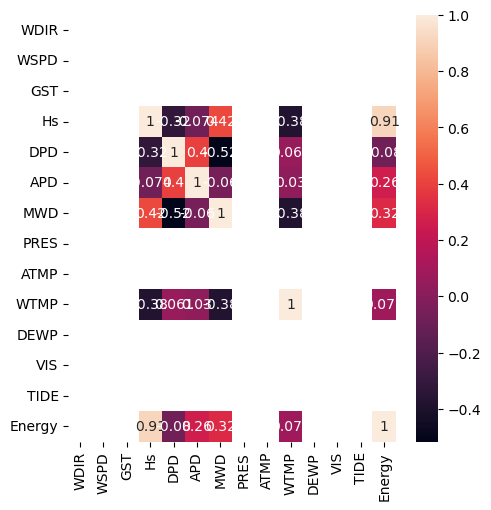

In [7]:
import seaborn as sns
dataset.describe()
print(dataset.head())
print(dataset.shape)
print(dataset.columns)

sns.displot(dataset["Energy"])
#sns.displot(datas["WVHT"])
sns.heatmap(dataset.corr(),annot=True)

In [8]:
df = pd.DataFrame(dataset)
df  = df.fillna(df.interpolate())
do1 = df['APD'][:]
do2 = df['Hs'][:]
do=997*9.81*9.81*do1*do2*do2/((64*3.14))

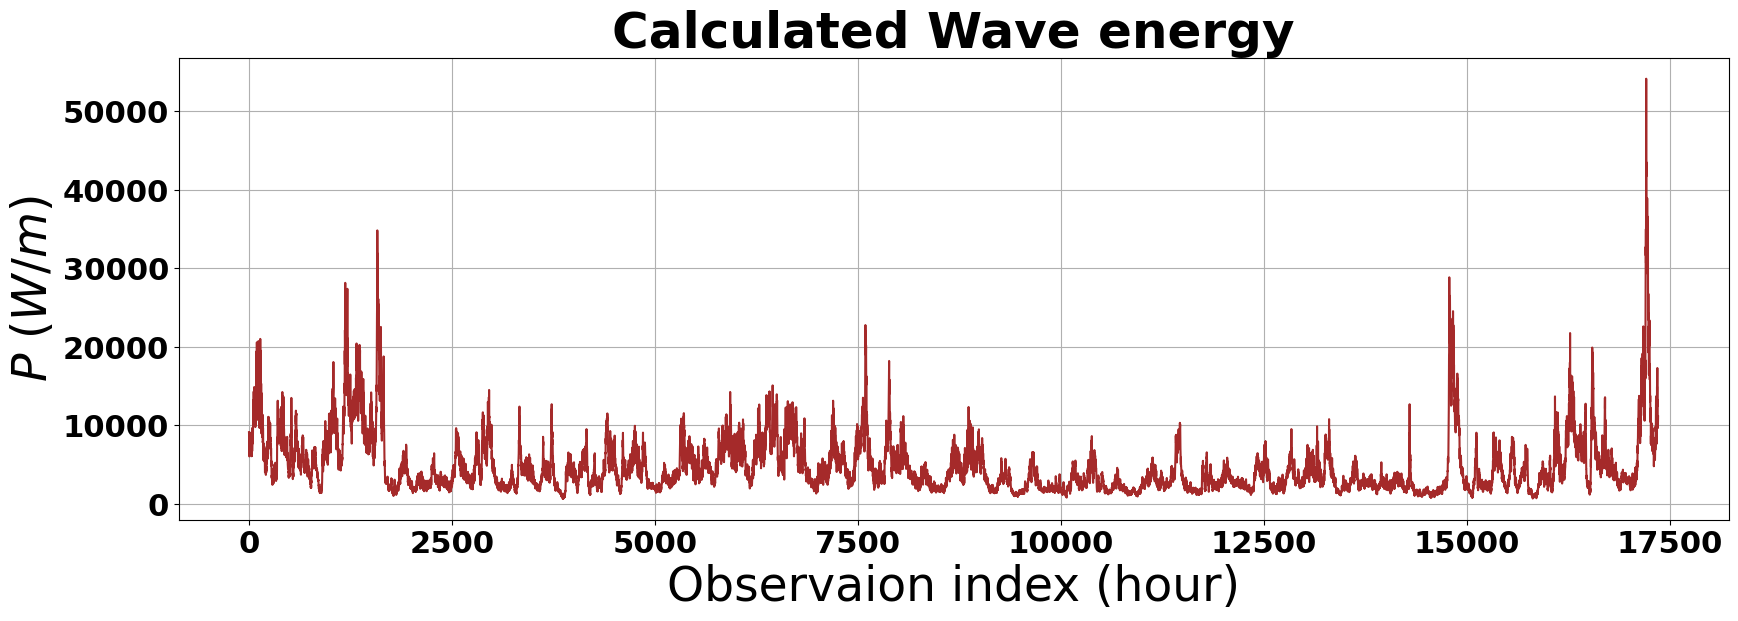

In [9]:
plt.figure(figsize=(20,6))
plt.plot(do.values, color='brown')  # Dark gold color
plt.title(r'Calculated Wave energy', fontsize=36, fontweight='bold')
plt.xlabel(r'Observaion index (hour)', fontsize=34)
plt.ylabel(r'$P$ $(W/m)$', fontsize=34)
plt.xticks(fontsize=22, fontweight='bold')
plt.yticks(fontsize=22, fontweight='bold')
plt.grid(True)

In [ ]:
#do = df['Hs'][:]

In [10]:
DO = []
for i in range(0, len(do)):
    DO.append([do[i]])
    scaler_DO = MinMaxScaler(feature_range=(np.min(do), np.max(do)))
DO = scaler_DO.fit_transform(DO)

In [11]:
# set IMFs = 8
eemd = EEMD()
eemd.noise_seed(12345)
imfs = eemd.eemd(DO.reshape(-1),None,8)

In [ ]:
#import dill
#dill.dump_session('notebook_Energy.db')

In [ ]:
#import dill
#dill.load_session('notebook_Energy.db')

In [12]:
c = int(len(DO) * .75)

In [13]:
# Look back
lookback_window = 10
imfs_prediction = []

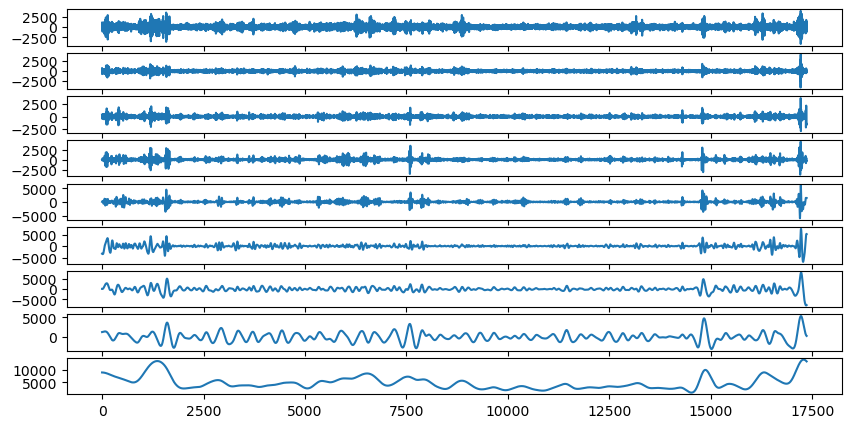

In [14]:
i = 1
for imf in imfs:
   plt.subplot(len(imfs), 1, i)
   plt.plot(imf)
   i += 1

plt.savefig('result_imf.png')
plt.show()

In [15]:
# Lead time = 30min*Pre_step ,if prtd
PRE_STEP = 24
test = np.zeros([len(DO) - c - lookback_window - PRE_STEP, 1])


In [18]:
# Train EEMD_LSTM

Tests=[]
i = 1

for imf in imfs:
    print('-'*45)
    print('This is  ' + str(i)  + '  time(s)')
    print('*'*45)
    X1_train, Y1_train, X1_test, Y1_test = data_split(imf_data(imf,1), c, lookback_window,PRE_STEP)
    X2_train, Y2_train, X2_test, Y2_test = data_split_LSTM(X1_train, Y1_train, X1_test, Y1_test)
    test += Y2_test
    model = LSTM_Model(X2_train,Y2_train,i)
    prediction_Y = model.predict(X2_test)
    imfs_prediction.append(prediction_Y)
    Tests.append(Y2_test)
    i+=1;

---------------------------------------------
This is  1  time(s)
*********************************************
Epoch 1/100
406/406 - 7s - loss: 202785.8125 - mean_squared_error: 202785.8125 - 7s/epoch - 17ms/step
Epoch 2/100
406/406 - 6s - loss: 202555.3906 - mean_squared_error: 202555.3906 - 6s/epoch - 14ms/step
Epoch 3/100
406/406 - 6s - loss: 202482.4219 - mean_squared_error: 202482.4219 - 6s/epoch - 14ms/step
Epoch 4/100
406/406 - 6s - loss: 202532.5625 - mean_squared_error: 202532.5625 - 6s/epoch - 15ms/step
Epoch 5/100
406/406 - 6s - loss: 202427.7969 - mean_squared_error: 202427.7969 - 6s/epoch - 15ms/step
Epoch 6/100
406/406 - 6s - loss: 202389.7188 - mean_squared_error: 202389.7188 - 6s/epoch - 15ms/step
Epoch 7/100
406/406 - 6s - loss: 202457.2969 - mean_squared_error: 202457.2969 - 6s/epoch - 15ms/step
Epoch 8/100
406/406 - 6s - loss: 203836.0312 - mean_squared_error: 203836.0312 - 6s/epoch - 15ms/step
Epoch 9/100
406/406 - 6s - loss: 202551.2500 - mean_squared_error: 20255

In [19]:
imfs_prediction = np.array(imfs_prediction)
prediction = [0.0 for i in range(len(test))]
prediction = np.array(prediction)
for i in range(len(test)):
    t = 0.0
    for imf_prediction in imfs_prediction:
        t += imf_prediction[i][0]
    prediction[i] = t

In [20]:
Tests=np.array(Tests)

---------------------------------------------
This is  IMF0 :
*********************************************
RMSE : 508.412344191969
RRMSE : 67679.29283815094
RRMSE : 67679.29283815094
RRMSE Hamed Definition: 100.46979508475542


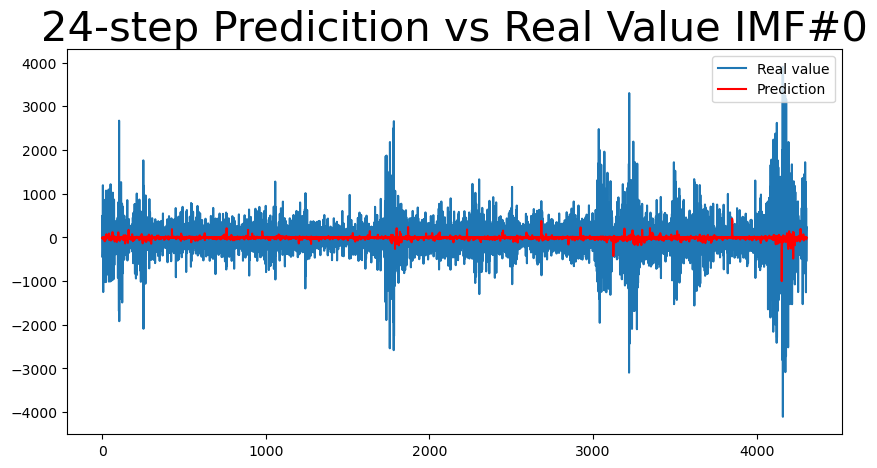

---------------------------------------------
This is  IMF1 :
*********************************************
RMSE : 287.2191059969718
RRMSE : 321.4214726770289
RRMSE : 321.4214726770289
RRMSE Hamed Definition: 99.96121425667135


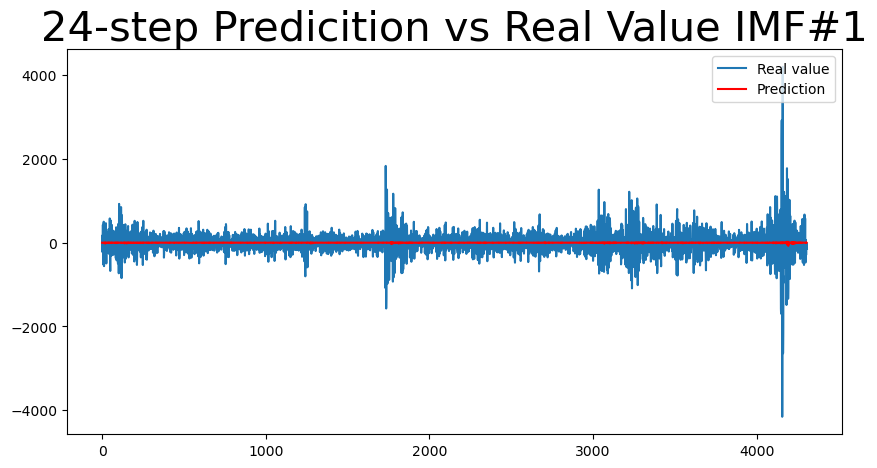

---------------------------------------------
This is  IMF2 :
*********************************************
RMSE : 300.1866712821496
RRMSE : 1215.0328717493862
RRMSE : 1215.032871749386
RRMSE Hamed Definition: 99.98461287129773


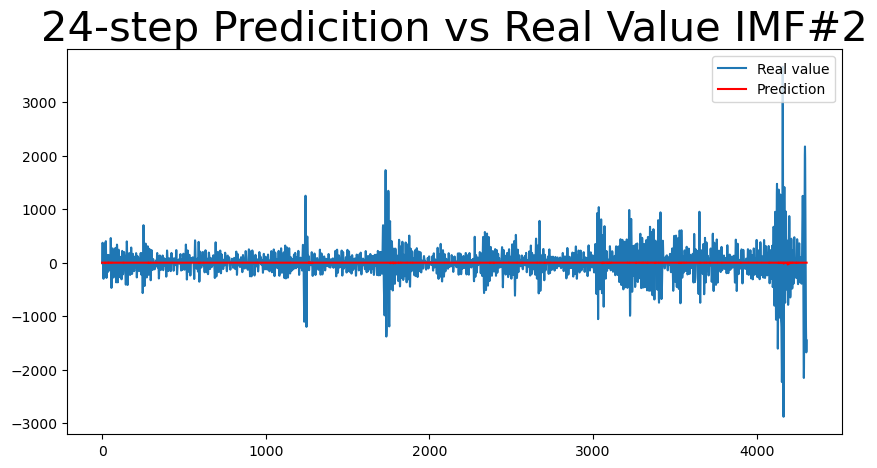

---------------------------------------------
This is  IMF3 :
*********************************************
RMSE : 492.36931350711683
RRMSE : 1577.6728983302305
RRMSE : 1577.6728983302305
RRMSE Hamed Definition: 103.05910743094564


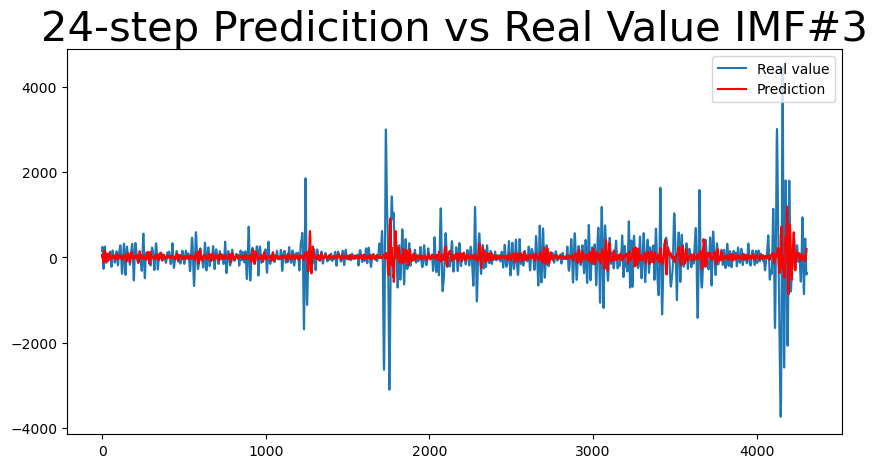

---------------------------------------------
This is  IMF4 :
*********************************************
RMSE : 709.0082715363169
RRMSE : 2774.2273312594652
RRMSE : 2774.2273312594652
RRMSE Hamed Definition: 85.53003578223841


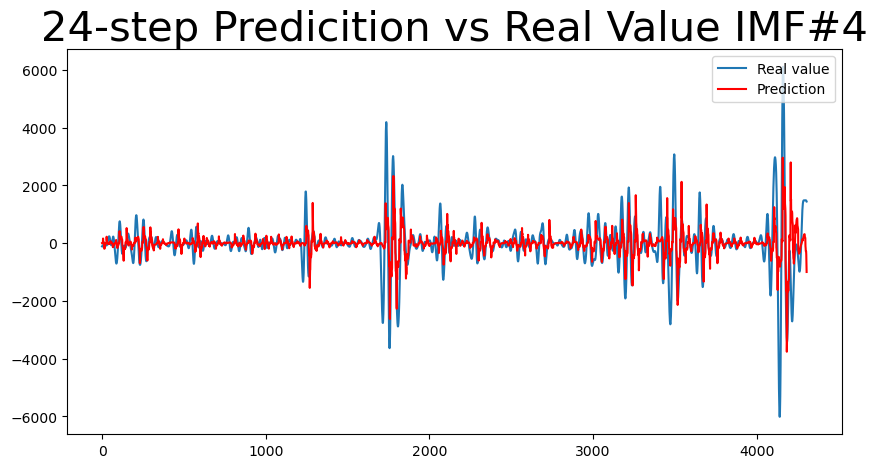

---------------------------------------------
This is  IMF5 :
*********************************************
RMSE : 1113.5558776798077
RRMSE : 1084.9176083904117
RRMSE : 1084.9176083904117
RRMSE Hamed Definition: 86.80113902216107


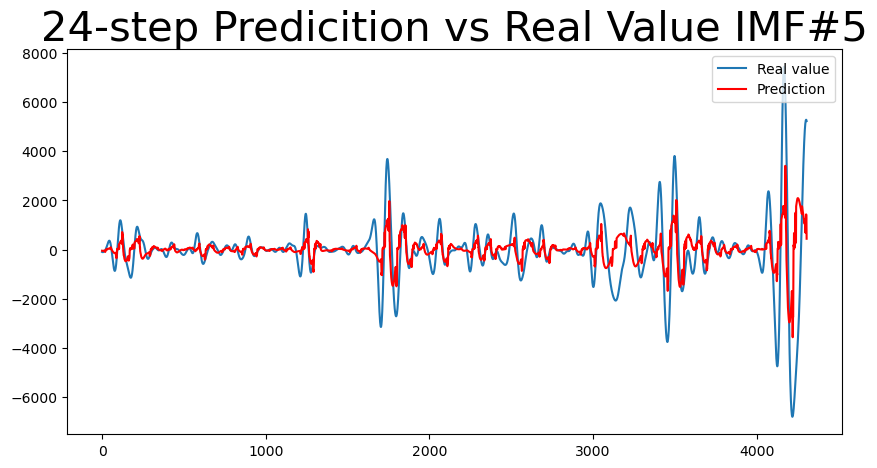

---------------------------------------------
This is  IMF6 :
*********************************************
RMSE : 1407.2672947580793
RRMSE : 74595.81188474504
RRMSE : 74595.81188474504
RRMSE Hamed Definition: 83.131270624177


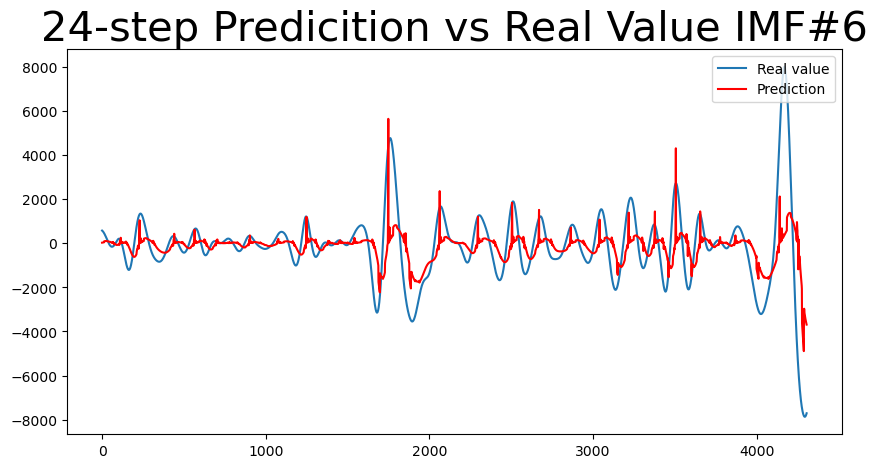

---------------------------------------------
This is  IMF7 :
*********************************************
RMSE : 727.3021756327416
RRMSE : 3406.3087784465133
RRMSE : 3406.3087784465133
RRMSE Hamed Definition: 50.223625554758996


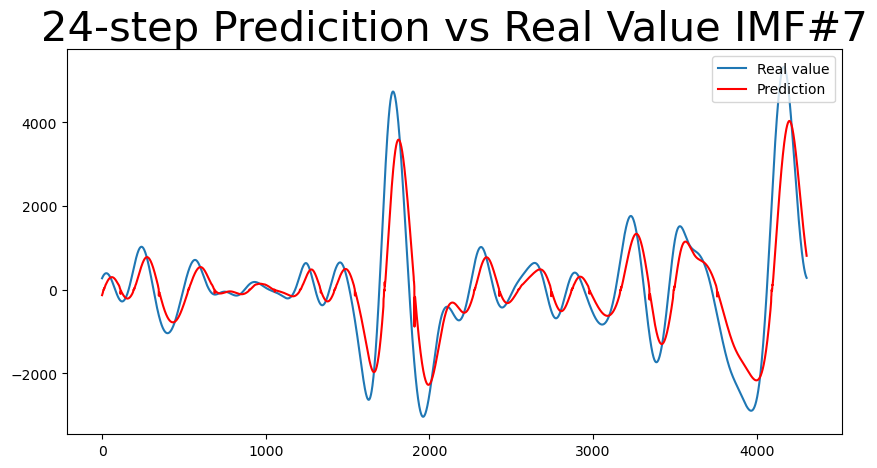

---------------------------------------------
This is  IMF8 :
*********************************************
RMSE : 490.35449466709855
RRMSE : 10.451963803669418
RRMSE : 10.451963803669418
RRMSE Hamed Definition: 8.450285929942769


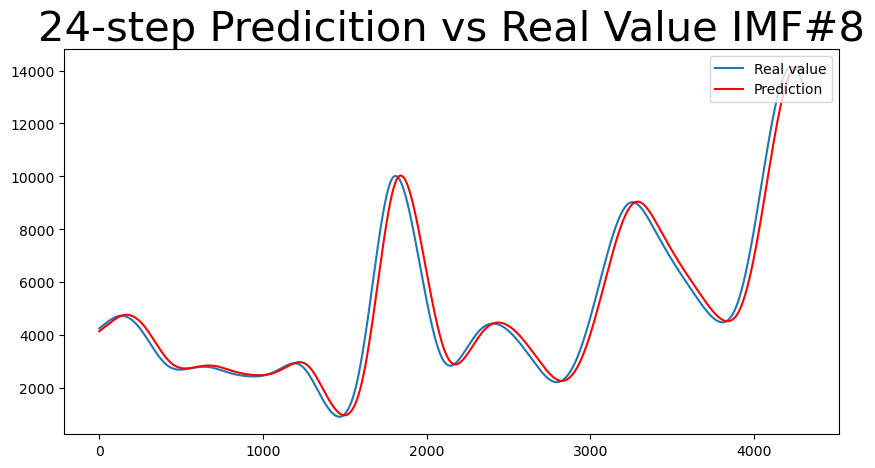

In [22]:
# evaluate forecasts for IMFs seperately
## IMF1

def ErIndx(test,prediction):
    sig=0.0
    for i in range(0,test.size):
        sig=sig+(test[i]-prediction[i])**2
    print("RMSE :",(sig*(1/test.size))**0.5)

    sig=0
    for i in range(0,test.size):
        sig=sig+((test[i]-prediction[i])/test[i])**2
    print("RRMSE :",(sig/test.size)**0.5*100)

    sig=0
    for i in range(test.size):
        sig=sig+((prediction[i]-test[i])**2)/(test[i]**2)
    print("RRMSE :",(sig/test.size)**0.5*100)


    sig1=0
    sig2=0
    for i in range(test.size):
        sig1=sig1+(test[i]-prediction[i])**2
        sig2=sig2+test[i]**2
    print("RRMSE Hamed Definition:",((sig1/sig2)**0.5)*100)


for t in range(0,imfs.shape[0]):
    # plot forecasts against actual outcomes
    print('-'*45)
    print('This is  IMF' + str(t)  + ' :')
    print('*'*45)


    ErIndx(Tests[t,:,0],imfs_prediction[t,:,0])
    plt.plot(Tests[t,:,0],label="Real value")
    plt.plot(imfs_prediction[t,:,0],color='red',label="Prediction")
    plt.legend(loc="upper right")
    plt.title(str(PRE_STEP)+"-step Predicition vs Real Value IMF#"+str(t) ,fontsize=30)
    plt.show()

In [23]:
prediction = prediction.reshape(prediction.shape[0], 1)

In [24]:
test = scaler_DO.inverse_transform(test)
prediction = scaler_DO.inverse_transform(prediction)

In [25]:
#%%
from scipy.stats import linregress

rmse = mean_squared_error(y_true=test, y_pred=prediction, squared=False)
print('scipy RMSE: {:.6f}'.format(rmse))

scipy RMSE: 3029.213417


c:\Users\ashkanreisi\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
sig=0.0

for i in range(0,test.size):
    sig=sig+(test[i]-prediction[i])**2
print((sig*(1/test.size))**0.5)

sig=0
for i in range(0,test.size):
    sig=sig+((test[i]-prediction[i])/test[i])**2
print((sig/test.size)**0.5*100)

sig=0
for i in range(test.size):
    sig=sig+((prediction[i]-test[i])**2)/(test[i]**2)
print((sig/test.size)**0.5*100)


sig1=0
sig2=0
for i in range(test.size):
    sig1=sig1+(test[i]-prediction[i])**2
    sig2=sig2+test[i]**2
print(((sig1/sig2)**0.5)*100)

[3029.21341667]
[63.91793807]
[63.91793807]
[44.484012]


RMSE : [3029.21341667]
RRMSE : [63.91793807]
RRMSE : [63.91793807]
RRMSE Hamed Definition: [44.484012]


Text(0.5, 1.0, 'EEMD LSTM')

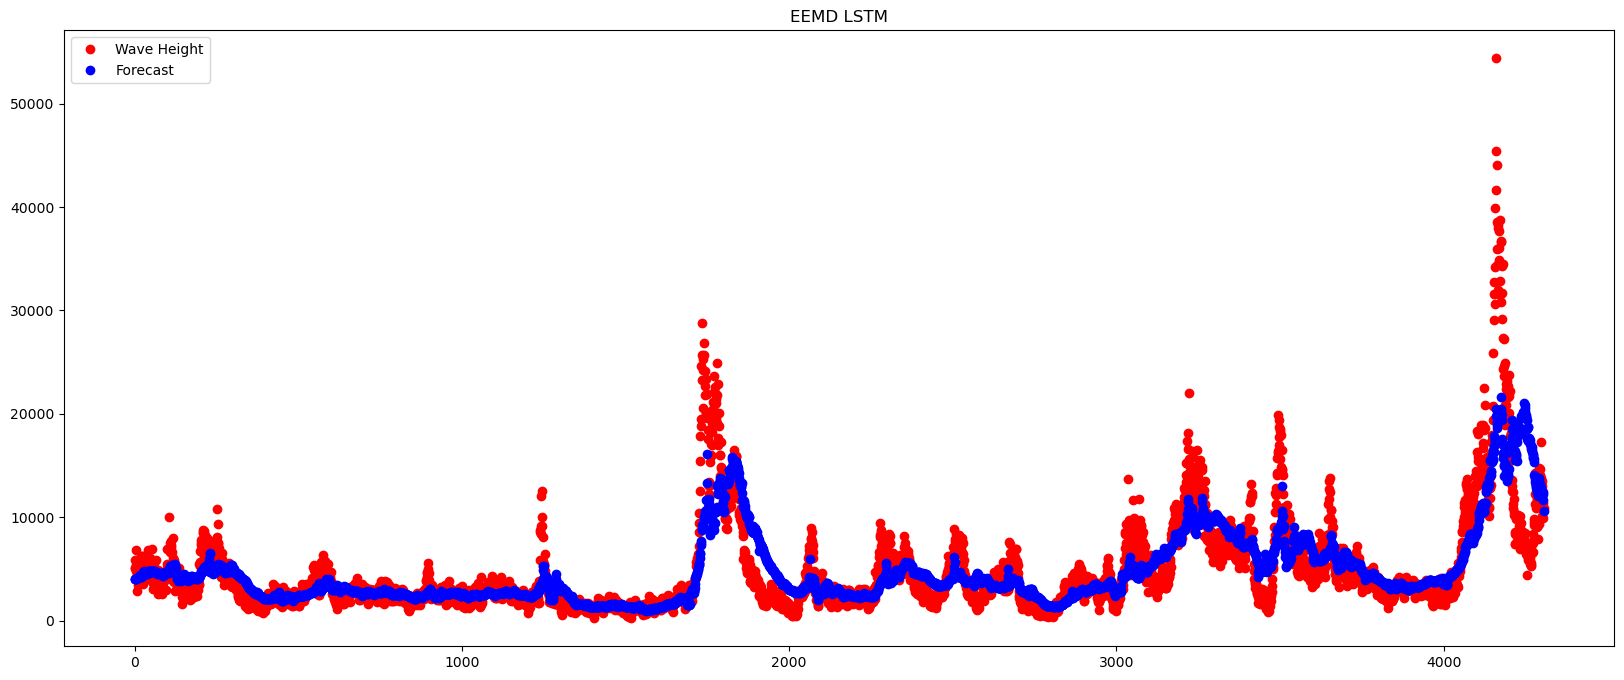

In [28]:
ErIndx(test,prediction)
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(test,'ro')
plt.plot(prediction,'bo')
ax.legend(['Wave Height', 'Forecast'])
plt.title("EEMD LSTM")

Text(0.5, 1.0, 'EEMD LSTM')

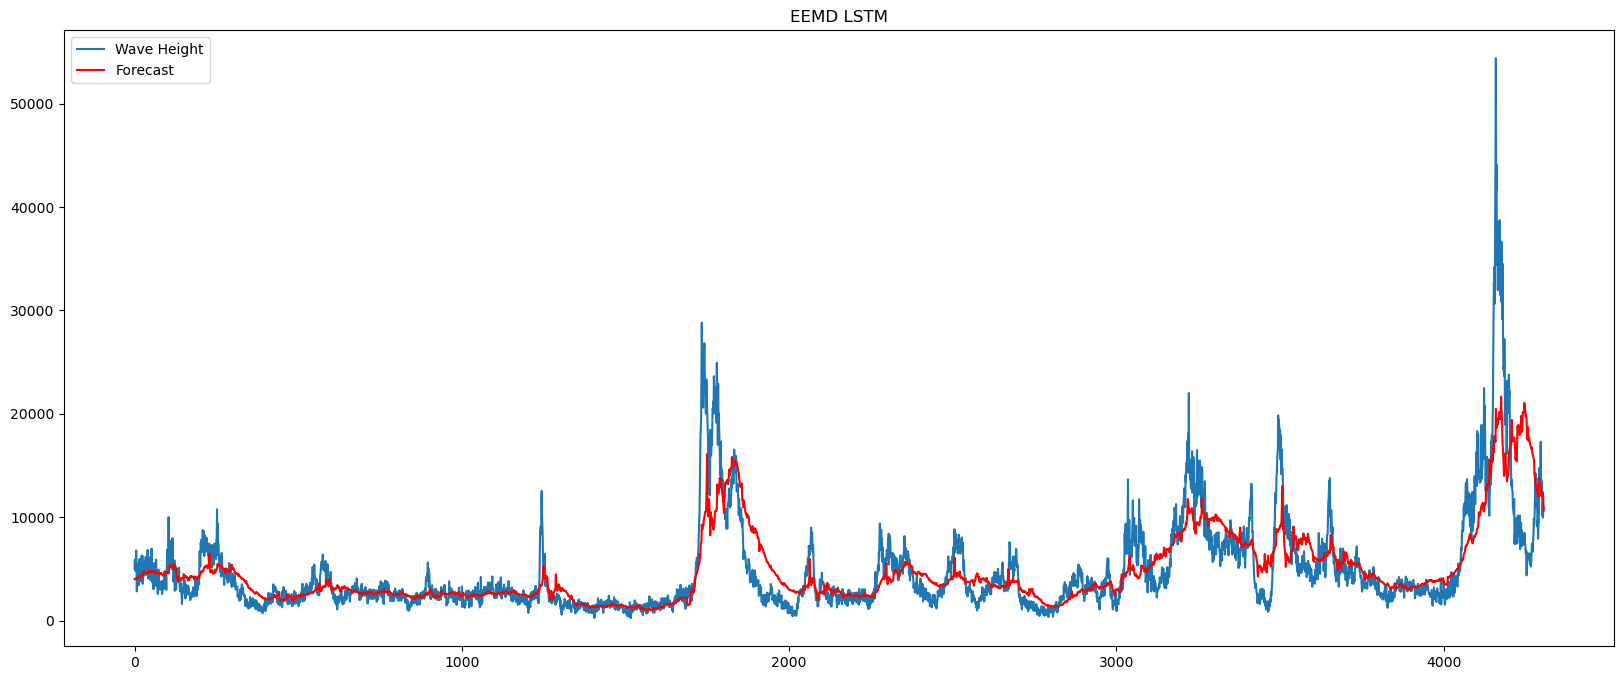

In [29]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(test)
plt.plot(prediction, color='red')
ax.legend(['Wave Height', 'Forecast'])
plt.title("EEMD LSTM")

In [ ]:
concatination.shape

NameError: name 'concatination' is not defined

In [ ]:
Diff=do-concatination
DO = []
for i in range(0, len(Diff)):
    DO.append([Diff[i]])
    scaler_Diff = MinMaxScaler(feature_range=(np.min(Diff), np.max(Diff)))
DO = scaler_DO.fit_transform(DO)

In [ ]:
# set IMFs = 8
eemdDiff = EEMD()
eemdDiff.noise_seed(12345)
imfsDiff = eemdDiff.eemd(DO.reshape(-1),None,8)

In [ ]:
# Look back
lookback_window = 10
imfs_prediction = []
imfs_prediction_Tr=[]

In [ ]:
i = 1
for imfDiff in imfsDiff:
   plt.subplot(len(imfsDiff), 1, i)
   plt.plot(imfDiff)
   i += 1

plt.savefig('result_imf.png')
plt.show()

In [ ]:
# Lead time = 30min*Pre_step ,if prtd
PRE_STEP = 24
test_2 = np.zeros([len(DO) - c - lookback_window - PRE_STEP, 1])

In [ ]:
imfs_prediction_2 = []

In [ ]:
import numpy as np
import pandas as pd


from pandas import read_csv
from pandas import DataFrame
from datetime import datetime
from matplotlib import pyplot
from pylab import mpl


from pandas import concat
from PyEMD import EEMD

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.layers import Dropout
from keras.layers import Activation

from scipy import interpolate, math
import matplotlib.pyplot as plt

from keras import Input, Model
from keras.layers import Dense
from keras.models import load_model


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# from sklearn.ensemble import IsolationForest


def data_split(data, train_len, lookback_window,PRE_STEP):
    data=data.reshape(np.shape(data)[0],np.shape(data)[1])
    WINDOW_SIZE = 10
    train = data[:train_len]
    test = data[train_len:]

    features = []
    predict = []
    for i in range(len(train) - WINDOW_SIZE - PRE_STEP):
        end_ix = i + WINDOW_SIZE
        out_end_ix = end_ix + PRE_STEP
        x = train[i:end_ix]
        y = train[out_end_ix,0]
        features.append(x)
        predict.append(y)
    features = np.array(features)
    predict = np.array(predict)
    predict=predict.reshape((np.shape(predict)[0],1))



    features1 = []
    predict1 = []
    for i in range(len(test) - WINDOW_SIZE - PRE_STEP):
        end_ix = i + WINDOW_SIZE
        out_end_ix = end_ix + PRE_STEP
        x = test[i:end_ix]
        y = test[out_end_ix,0]
        features1.append(x)
        predict1.append(y)
    features1 = np.array(features1)
    predict1 = np.array(predict1)
    predict1=predict1.reshape((np.shape(predict1)[0],1))

    return (features,predict, features1,predict1,data)



def data_split_LSTM(X_train, Y_train, X_test, y_test):  # data split f
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)
    return (X_train, Y_train, X_test, y_test)


def imf_data(data, data2, lookback_window):
    X1 = []
    X2=[]
    for i in range(lookback_window, len(data)):
        X1.append(data[i - lookback_window:i])
        X2.append(data2[i - lookback_window:i])
    X1.append(data[len(data) - 1:len(data)])
    X2.append(data2[len(data) - 1:len(data)])
    X_train = np.array(X1)
    X_train=np.expand_dims(X_train, axis=1)
    temp= np.array(X2)
    X_train=np.concatenate((X_train,temp[:,None]),axis=1)
    print(X_train.shape)
    print(type(X_train))
   # print(X1)
   # print(X2)
    print(X_train)
    print(X_train[9,0,0])
    return X_train


def visualize(history):
    plt.rcParams['figure.figsize'] = (10.0, 6.0)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


def LSTM_Model(X_train, Y_train,i):


    from keras.layers import LeakyReLU
    from tensorflow.keras.optimizers import Adam
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]),
    stateful=False, return_sequences = True))
    #model.add(Dropout(0.2))
    model.add(LSTM(64, activation='relu', return_sequences = True))
    model.add(LSTM(64, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate = 0.001), metrics='MeanSquaredError')
    model.fit(X_train, Y_train, epochs=100, verbose=2, shuffle=False)
    return (model)


def RMSE(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    return rmse


def MAPE(Y_true, Y_pred):
    Y_true, Y_pred = np.array(Y_true), np.array(Y_pred)
    return np.mean(np.fabs((Y_true - Y_pred) / Y_true)) * 100

def calc_corr(a, b):
    a_avg = sum(a)/len(a)
    b_avg = sum(b)/len(b)
    cov_ab = sum([(x - a_avg)*(y - b_avg) for x,y in zip(a, b)])
    sq = math.sqrt(sum([(x - a_avg)**2 for x in a])*sum([(x - b_avg)**2 for x in b]))

    corr_factor = cov_ab/sq

    return corr_factor

In [ ]:
# Train EEMD_LSTM
i = 1
j=0
for imf in imfs:
    print('-'*45)
    print('This is  ' + str(i)  + '  time(s)')
    print('*'*45)
    #X1_train, Y1_train, X1_test, Y1_test = data_split(imf_data(imf,1), c, lookback_window,PRE_STEP)
    X1_train_2, Y1_train_2, X1_test_2, Y1_test_2 ,data = data_split(imf_data(imfsDiff[j,:],imf,1), c, lookback_window,PRE_STEP)
    X2_train_2, Y2_train_2, X2_test_2, Y2_test_2 = data_split_LSTM(X1_train_2, Y1_train_2, X1_test_2, Y1_test_2)
    test_2 += Y2_test_2
    model_2 = LSTM_Model(X2_train_2,Y2_train_2,i)
    prediction_Y_2 = model_2.predict(X2_test_2)
    imfs_prediction_2.append(prediction_Y)
    i+=1;
    j+=1;

In [ ]:
imfs_prediction_2 = np.array(imfs_prediction_2)
prediction_2 = [0.0 for i in range(len(test_2))]
prediction_2 = np.array(prediction_2)
for i in range(len(test_2)):
    t = 0.0
    for imf_prediction_2 in imfs_prediction_2:
        t += imf_prediction_2[i][0]
    prediction_2[i] = t

In [ ]:
prediction_2 = prediction_2.reshape(prediction_2.shape[0], 1)

In [ ]:
#can be checked later
test_2 = scaler_DO.inverse_transform(test_2)
prediction_2 = scaler_DO.inverse_transform(prediction_2)

In [ ]:
# EVALUATION
rmse=format(RMSE(test_2,prediction_2),'.4f')
mape=format(MAPE(test_2,prediction_2),'.4f')
r2 = format(r2_score(test_2, prediction_2), '.4f')
mae = format(mean_absolute_error(test_2, prediction_2), '.4f')
cor2 = calc_corr(test_2, prediction_2)
SI =RMSE(test_2,prediction_2)/(np.mean(test_2))
Bias = np.mean(test_2) - np.mean(prediction_2)
print('RMSE:' + str(rmse) + '\n' +  'MAE:' + str(mae) + '\n' + 'MAPE:' + str(mape) + '\n' + 'R2:' + str(r2)  + '\n' + 'r:' + str(cor2)+ '\n' + 'SI:' + str(SI)+ '\n' + 'Bias:' + str(Bias))

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(test_2)
plt.plot(prediction_2, color='red')
ax.legend(['Wave Height', 'Forecast'])
plt.title("EEMD LSTM")

In [ ]:
#importing predciton to Clipboard
import pandas as pd
df = pd.DataFrame(temp2)
df.to_clipboard(index=False,header=False)

In [ ]:
def gen_graph(history, title):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title(title)
gen_graph(model, "Accuracy, training vs. validation scores")

In [ ]:
# LSTM  Model

X1_train_lstm, Y1_train_lstm, X1_test_lstm, Y1_test_lstm = data_split(DO, c, lookback_window,PRE_STEP)

X2_train_lstm, Y2_train_lstm, X2_test_lstm, Y2_test_lstm = data_split_LSTM(X1_train_lstm, Y1_train_lstm, X1_test_lstm, Y1_test_lstm)

model = LSTM_Model(X2_train_lstm,Y2_train_lstm,1)
prediction_Y_lstm = model.predict(X2_test_lstm)
prediction_Y_lstm = np.array(prediction_Y_lstm)

prediction_lstm = scaler_DO.inverse_transform(prediction_Y_lstm)

In [ ]:
rmse_LSTM=format(RMSE(test,prediction_lstm),'.4f')
mape_LSTM=format(MAPE(test,prediction_lstm),'.4f')
r2_LSTM = format(r2_score(test, prediction_lstm), '.4f')
mae_LSTM = format(mean_absolute_error(test, prediction_lstm), '.4f')
cor2_LSTM = calc_corr(test, prediction_lstm)
SI_LSTM =RMSE(test,prediction_lstm)/(np.mean(test))
Bias_LSTM = np.mean(test) - np.mean(prediction_lstm)

print('LSTM:' +'\n'+'RMSE:' + str(rmse_LSTM) + '\n' +  'MAE:' + str(mae_LSTM) + '\n' + 'MAPE:' + str(mape_LSTM) + '\n' + 'R2:' + str(r2_LSTM)+ '\n' + 'r:' + str(cor2_LSTM)+ '\n' + 'SI:' + str(SI_LSTM)+ '\n' + 'Bias:' + str(Bias_LSTM))

In [ ]:
fig = plt.figure(figsize=(20,8))
ax = plt.gca()
plt.plot(test)
plt.plot(prediction_lstm, color='red')
ax.legend(['Wave Height', 'Forecast'])
plt.title("Non-EEMD LSTM")